In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Model : Temporal Fusion Transformer(TFT)
Why this model:
1. Pretrained
2. Uses Attention mechanism
3. Supports Multivariate features
4. Can handle irregular time series data
5. Robust to missing data (rows)

In [1]:
!pip install pytorch_forecasting
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Here an additional column 'Date_idx' is needed for this model TFT

Why?

Company-Specific Time Index:
1. The Date column is repeated for all companies, but the temporal order of the data is specific to each company.
For example, 31-03-2000 is the first quarter for Company_001, but it is also the first quarter for Company_002. The model needs to understand the sequential order of quarters within each company.
2. TFT require a numerical time index (time_idx) to define the temporal order of the data. This index must be company-specific to ensure the model understands the sequence of quarters for each company.
3. If we use the Date column directly, the model might not distinguish between the same date for different companies. A company-specific numerical index ensures the temporal order is preserved for each company and avoids confusion with repeated Dates.


In below step, we will see that the Date_idx gives a certain numerical value to each unique date.

In [ ]:
try:
  company_data_df = pd.read_csv("dataset_preprocessed.csv")

  # Convert date to numerical index for time-series modeling
  company_data_df= company_data_df.sort_values(by=["Company", "Date"])  

  # Create a company-specific time index
  company_data_df['Date_idx'] = company_data_df.groupby('Company').cumcount()
  print("company_data_df['Date_idx'] : ",company_data_df['Date_idx'][98:300])

except FileNotFoundError:
    print("Error: 'dataset_preprocessed.csv' not found. Please run the preprocessing steps first.")
    pass


company_data_df['Date_idx'] :  98     98
99      0
100     1
101     2
102     3
       ..
295    97
296    98
297     0
298     1
299     2
Name: Date_idx, Length: 202, dtype: int64


In [49]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_lightning import Trainer
from lightning.pytorch import Trainer
import torch
import torchmetrics # Import the loss from torchmetrics
from sklearn.metrics import accuracy_score # Import accuracy_score for evaluation

Forming train dataset and test dataset. Splitting the data to train and test in the ratio 4:1

In [11]:
# keeping aside 20% data for test ~18 values
data_train_val = company_data_df[company_data_df['Date'] < '2020-04-01']
test_data = company_data_df[company_data_df['Date'] >= '2020-04-01']

Here instead of cross validation, Walk-Forward Validation method is used.

In Walk-Forward Validation, the training set expands with each fold while the validation set moves forward in time. 

This is particularly useful for time-series forecasting tasks because it ensures that the model is trained on past data and tested on future data, avoiding data leakage and respecting the temporal order.

In [ ]:
def walk_forward_splits(data, n_splits=4, min_val_size = 1):    
    splits = []
    data = data.sort_values(by=["Company", "Date_idx"])
    unique_dates = sorted(data['Date_idx'].unique())
    split_size = len(unique_dates) // (n_splits+1)

    for i in range(n_splits):
        train_end_idx = split_size * (i + 1)
        val_start_idx = train_end_idx
        val_end_idx = val_start_idx + split_size

        # Ensure validation set has a minimum size
        if val_end_idx > len(unique_dates) or len(unique_dates[val_start_idx:val_end_idx]) < min_val_size:
            break

        train_dates = unique_dates[:train_end_idx]
        val_dates = unique_dates[val_start_idx:val_end_idx]

        train_data = data[data['Date_idx'].isin(train_dates)]
        val_data = data[data['Date_idx'].isin(val_dates)]

        splits.append((train_data, val_data))

    return splits

In [ ]:
from torchmetrics import Metric
class BCEWithLogitsLossMetric(Metric):
    def __init__(self):
        super().__init__()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
      pass

    def compute(self):
      pass

    def forward(self, y_pred, y_true):
        return self.loss_fn(y_pred.squeeze(), y_true.float())

In [ ]:
def create_tft_datasets(train_data, val_data): 
  train_dataset = TimeSeriesDataSet(
      train_data,
      time_idx="Date_idx",
      target="Target",
      group_ids=["Company"],
      max_encoder_length=12,  # Use past 12 quarters
      max_prediction_length=1,  # Predict next quarter
      static_categoricals=["Company"],
      time_varying_known_reals=["Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio"],
      time_varying_unknown_reals=["Target"],
  )

  val_dataset = TimeSeriesDataSet.from_dataset(
       train_dataset, # Use train_dataset to copy scalers and other parameters
       val_data,      # Provide the validation data
       # Adjust parameters if needed, but keep consistent with train_dataset  
       stop_randomization=True,
       predict_mode=True,
       add_relative_time_idx = True
  )

  return train_dataset, val_dataset

In [ ]:
splits = walk_forward_splits(data_train_val, n_splits=4)

val_results = []

for fold_idx, (train_data, val_data) in enumerate(splits):
  print(f"\nTraining fold {fold_idx + 1}...")

  train_dataset, val_dataset = create_tft_datasets(train_data, val_data)

  # Create dataloaders
  train_dataloader = train_dataset.to_dataloader(train=True, batch_size=8)
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=8)  

  custom_loss_metric = BCEWithLogitsLossMetric()

  # Define model
  tft = TemporalFusionTransformer.from_dataset(
      train_dataset,
      learning_rate=0.01,
      hidden_size=16,
      attention_head_size=4,
      dropout=0.1,
      hidden_continuous_size=16,
      output_size=1,  # Binary classification
      loss=custom_loss_metric,
  )

  # Train model
  trainer = Trainer(max_epochs=10)
  trainer.fit(tft, train_dataloader, val_dataloader)  


Training fold 1...


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | Mult

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



Training fold 2...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 3...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.6 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 4...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.6 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
for fold_idx, (train_data, val_data) in enumerate(splits):
  print(f"\nTraining fold {fold_idx + 1}...")

  # Evaluate model on validation set
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=8)  
  val_predictions = trainer.validate(model=tft, dataloaders=val_dataloader)  

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 1...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 2...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 3...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 4...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

Evaluation

In [ ]:
# Create TFT dataset for the test set
test_dataset = TimeSeriesDataSet(
    test_data,
    time_idx="Date_idx",
    target="Target",
    group_ids=["Company"],
    max_encoder_length=12,  # Use past 12 quarters
    max_prediction_length=1,  # Predict next quarter
    static_categoricals=["Company"],
    time_varying_known_reals=["Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio"],
    time_varying_unknown_reals=["Target"],
)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=16)

# Evaluate model on test set
test_predictions = trainer.test(model=tft, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │    0.9414722919464111     │
│         test_MAPE         │        40287088.0         │
│         test_RMSE         │     1.150607943534851     │
│        test_SMAPE         │    1.6564548015594482     │
│         test_loss         │    0.6567850112915039     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# Collect predictions and true labels
all_preds = []
all_targets = []

for batch in test_dataloader:
    x, y = batch
    preds = tft(x).prediction
    preds = torch.sigmoid(preds).round().view(-1)  # Apply sigmoid and round for binary classification
    all_preds.append(preds)
    all_targets.append(y[0].view(-1))


# Flatten the lists
all_preds = torch.cat(all_preds).detach().cpu().numpy()
all_targets = torch.cat(all_targets).detach().cpu().numpy()


In [95]:
print(all_preds)
print(all_targets)
# Print the shapes to verify they are now 1D
print(f"Shape of all_targets: {all_targets.shape}")
print(f"Shape of all_preds: {all_preds.shape}")

[0. 0. 1. ... 1. 1. 1.]
[1 1 0 ... 1 1 1]
Shape of all_targets: (1188,)
Shape of all_preds: (1188,)


In [96]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_targets, all_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[326 215]
 [261 386]]


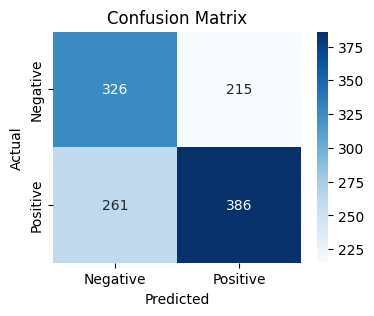

In [100]:
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()